In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
heartData = pd.read_csv("heart-failure-prediction/heart.csv")
# Entfernen unangegebener Cholersterin Beobachtungen und Frauen
heartData = heartData[(heartData["Sex"] != "F") & (heartData["Cholesterol"] != 0)]
heartData = heartData.drop(columns=["ST_Slope" ,"RestingECG", "ChestPainType", "ExerciseAngina"])
heartData

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,M,140,289,0,172,0.0,0
2,37,M,130,283,0,98,0.0,0
4,54,M,150,195,0,122,0.0,0
5,39,M,120,339,0,170,0.0,0
7,54,M,110,208,0,142,0.0,0
...,...,...,...,...,...,...,...,...
911,59,M,164,176,1,90,1.0,1
913,45,M,110,264,0,132,1.2,1
914,68,M,144,193,1,141,3.4,1
915,57,M,130,131,0,115,1.2,1


In [3]:
#Entfernen von Cholesterin
q1 = heartData['Cholesterol'].quantile(0.25)
q3 = heartData['Cholesterol'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['Cholesterol'] <= upper_limit) & (heartData['Cholesterol'] >= lower_limit)]
heartData = new_df.copy()

# Entfernen von RestingBP
q1 = heartData['RestingBP'].quantile(0.25)
q3 = heartData['RestingBP'].quantile(0.75)
iqr = q3-q1
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)
# trimming - delete the outlier data
new_df = heartData.loc[(heartData['RestingBP'] <= upper_limit) & (heartData['RestingBP'] >= lower_limit)]
heartData = new_df.copy()

In [4]:
# Umwandlung der Spalte "Sex" in nummerischen Wert
heartData["Sex"] = heartData["Sex"].apply(lambda x: 0 if x == "M" else 1)

In [12]:
# Features und Zielvariable
X = heartData[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]
y = heartData["HeartDisease"]

# Daten normalisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalisierte Daten und Zielvariable zusammenfügen
heartData = pd.DataFrame(X_scaled, columns=['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'])
heartData['HeartDisease'] = y.values
heartData

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,-1.363021,0.513670,1.097452,-0.468993,1.355882,-0.893693,0
1,-1.675021,-0.141354,0.970628,-0.468993,-1.629098,-0.893693,0
2,0.092982,1.168694,-0.889457,-0.468993,-0.660996,-0.893693,0
3,-1.467021,-0.796377,2.154319,-0.468993,1.275207,-0.893693,0
4,0.092982,-1.451401,-0.614672,-0.468993,0.145755,-0.893693,0
...,...,...,...,...,...,...,...
533,0.612982,2.085727,-1.291067,2.132227,-1.951799,0.016409,1
534,-0.843020,-1.451401,0.569019,-0.468993,-0.257621,0.198429,1
535,1.548984,0.775679,-0.931732,2.132227,0.105418,2.200652,1
536,0.404982,-0.141354,-2.242247,-0.468993,-0.943359,0.198429,1


In [10]:
# Lineare Regression mit statsmodels
model = smf.ols('HeartDisease ~ Age + RestingBP + Cholesterol + FastingBS + MaxHR + Oldpeak', data=heartData)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           HeartDisease   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     48.75
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.16e-47
Time:                        22:22:34   Log-Likelihood:                -268.85
No. Observations:                 538   AIC:                             551.7
Df Residuals:                     531   BIC:                             581.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5576      0.017     32.218      

0.6689081966353669
0.5880034310597542


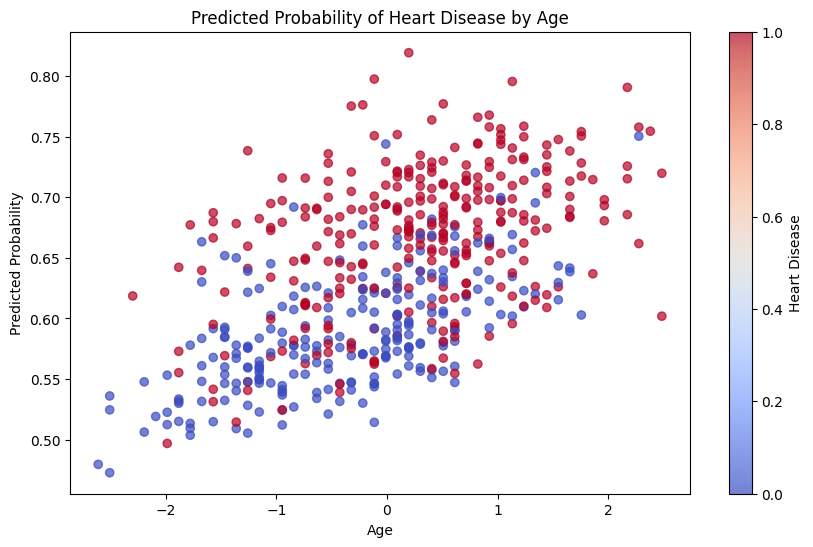

In [11]:
def predHD(Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak):
    predHD = (Age * 0.0469 + RestingBP * (-0.0073) + Cholesterol * 0.0368 + 
              FastingBS * 0.0333 + MaxHR * (-0.1291) + Oldpeak * 0.1991 + 0.5576)
    return 1 / (1 + np.exp(-predHD))

# Beispiel-Daten
df = heartData.copy()

# Vorhersage der Wahrscheinlichkeiten für jede Zeile im DataFrame
df['predicted_prob'] = df.apply(lambda row: predHD(row['Age'], row['RestingBP'], row['Cholesterol'], row['FastingBS'], row['MaxHR'], row['Oldpeak']), axis=1)

# Trennung der Daten nach Herzkrankheit und keiner Herzkrankheit
hd = df[df['HeartDisease'] == 1]
nd = df[df['HeartDisease'] == 0]

print(hd["predicted_prob"].mean())
print(nd["predicted_prob"].mean())

# Visualisierung der vorhergesagten Wahrscheinlichkeiten gegen das Alter
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['predicted_prob'], c=df['HeartDisease'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Heart Disease')
plt.xlabel('Age')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of Heart Disease by Age')
plt.show()

In [16]:
# 	Age 	Sex 	RestingBP 	Cholesterol 	FastingBS 	MaxHR 	Oldpeak 	HeartDisease
#predHD(Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak)
predHD(1.363021, 	0.513670, 	1.097452, 	-0.468993, 	1.355882, 	-0.893693)
predHD(0.612982, 	2.085727, 	-1.291067, 	2.132227, 	-1.951799, 	0.016409)#1

0.5718898836589356